In [1]:
import numpy as np
import requests, gzip, os, hashlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#fetch data
path='/mnt/e/ADITYA/EDUCATION/ML/Jupyter Lab/MNIST/mnist-from-numpy/data'
def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

In [3]:
X = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [4]:
#Validation split
rand=np.arange(60000)
np.random.shuffle(rand)
train_no=rand[:50000]

val_no=np.setdiff1d(rand,train_no)

X_train,X_val=X[train_no,:,:],X[val_no,:,:]
Y_train,Y_val=Y[train_no],Y[val_no]

In [5]:
#Sigmoid and its derivative
def sigmoid(x):
    return 1/(np.exp(-x)+1)
def d_sigmoid(x):
    return (np.exp(-x))/((np.exp(-x)+1)**2)


#Softmax
def softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)
    
def d_softmax(x):
    exp_element=np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))
     

In [6]:
def init(x,y):
    layer=np.random.uniform(-1.,1.,size=(x,y))/np.sqrt(x*y)
    return layer.astype(np.float32)

np.random.seed(42)
l1=init(28*28,128)
l2=init(128,10)


In [19]:
#forward and backward pass
def forward_backward_pass(x,y):
    targets = np.zeros((len(y),10), np.float32)
    targets[range(targets.shape[0]),y] = 1
 
    
    x_l1p=x.dot(l1)
    x_sigmoid=sigmoid(x_l1p)
    x_l2p=x_sigmoid.dot(l2)
    out=softmax(x_l2p)
    print(out.shape)
 
    error=2*(out-targets)/out.shape[0]*d_softmax(x_l2p)
    update_l2=x_sigmoid.T@error
    
    
    error=((l2).dot(error.T)).T*d_sigmoid(x_l1p)
    update_l1=x.T@error

    return out,update_l1,update_l2 


In [21]:
epochs=10
lr=0.001
batch=64

losses,accuracies,val_accuracies=[],[],[]

for i in range(epochs):
    sample=np.random.randint(0,X_train.shape[0],size=(batch))
    x=X_train[sample].reshape((-1,28*28))
    y=Y_train[sample]
 

    out,update_l1,update_l2=forward_backward_pass(x,y)
  
    category=np.argmax(out,axis=1)
    accuracy=(category==y).mean()
    accuracies.append(accuracy)
    
    loss=((category-y)**2).mean()
    losses.append(loss.item())
    
    l1=l1-lr*update_l1
    l2=l2-lr*update_l2
    
    if(i%20==0):    
        X_val=X_val.reshape((-1,28*28))
        val_out=np.argmax(softmax(sigmoid(X_val.dot(l1)).dot(l2)),axis=1)
        val_acc=(val_out==Y_val).mean()
        val_accuracies.append(val_acc.item())
    if(i%500==0): print(f'For {i}th epoch: train accuracy: {accuracy:.3f} | validation accuracy:{val_acc:.3f}')



(64, 10)
For 0th epoch: train accuracy: 0.141 | validation accuracy:0.090
(64, 10)
(64, 10)
(64, 10)
(64, 10)
(64, 10)
(64, 10)
(64, 10)
(64, 10)
(64, 10)


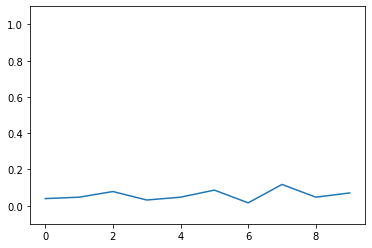

In [9]:
plt.ylim(-0.1, 1.1)
plot(accuracies)


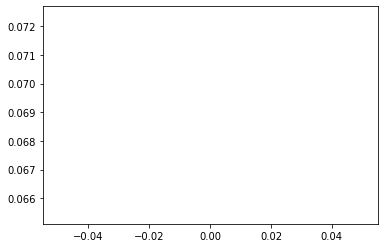

In [10]:
plot(val_accuracies)

In [11]:
test_out=np.argmax(softmax(sigmoid(X_test.dot(l1)).dot(l2)),axis=1)
test_acc=(test_out==Y_test).mean().item()
print(f'Test accuracy = {test_acc*100:.2f}%')
 

Test accuracy = 7.37%


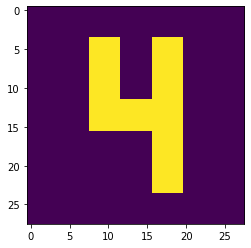

In [12]:
m = [[0,0,0,0,0,0,0],
     [0,0,255,0,255,0,0],
     [0,0,255,0,255,0,0],
     [0,0,255,255,255,0,0],
     [0,0,0,0,255,0,0],
     [0,0,0,0,255,0,0],
     [0,0,0,0,0,0,0]]
# upscale to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
imshow(m.reshape(28,28))
m=m.reshape(1,-1)

In [14]:
x = np.argmax(softmax(np.maximum(m.dot(l1),0).dot(l2)),axis=1)
x



array([0])

In [18]:
l1


array([[-7.9208513e-04,  2.8455637e-03,  1.4646830e-03, ...,
        -4.6020158e-04,  2.0077715e-03,  2.2774558e-03],
       [-3.1128346e-03,  6.7852598e-05, -5.2142178e-04, ...,
        -1.1558544e-03, -2.0866422e-03,  3.5861213e-04],
       [ 2.7536429e-03,  1.2376250e-03,  4.4232793e-04, ...,
         1.2420909e-03,  8.1407465e-04,  2.3831520e-03],
       ...,
       [-4.8830349e-05,  6.0965895e-04, -2.5888244e-03, ...,
        -2.5404603e-03,  3.0673348e-04,  5.6949357e-04],
       [ 4.0616604e-04,  2.9352377e-03, -1.1387233e-03, ...,
         2.8009422e-03, -2.8184371e-03,  1.9042534e-04],
       [-3.7994463e-04,  1.5051493e-03, -1.2513590e-03, ...,
         1.4320496e-03,  1.6163822e-03, -1.6940964e-03]], dtype=float32)

In [76]:
l2

array([[ 0.04690962, -0.0130793 ,  0.04658106, ..., -0.00867934,
         0.02573742,  0.01303842],
       [-0.01698802, -0.01933409,  0.02566955, ...,  0.04026119,
         0.01123069,  0.04119075],
       [ 0.02205069, -0.01296149,  0.04153036, ..., -0.0131658 ,
        -0.016242  ,  0.04552076],
       ...,
       [ 0.02108645,  0.03569334,  0.0107418 , ..., -0.02068027,
         0.01653735,  0.0362249 ],
       [ 0.04815861,  0.03505921,  0.0452162 , ...,  0.0330244 ,
        -0.01349052, -0.01010745],
       [ 0.01047709,  0.01278369, -0.0255689 , ..., -0.01000593,
        -0.02541646, -0.02679157]], dtype=float32)